In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


Import Movies, also remove the exta repeating columns with the same movieid

In [2]:
# Set the root directory
root = '/kaggle/input/sentiment-prediction-on-movie-reviews'

# Load the movies dataset
movies=pd.read_csv(f"{root}/movies.csv")

# Display the data types of columns
print(movies.dtypes)

movieid                  object
title                    object
audienceScore           float64
rating                   object
ratingContents           object
releaseDateTheaters      object
releaseDateStreaming     object
runtimeMinutes          float64
genre                    object
originalLanguage         object
director                 object
boxOffice                object
distributor              object
soundType                object
dtype: object


# Clean and preprocess columns


In [3]:
#For categoric valirables sort them and merge them
#remove all non alphanumeric characters
movies['movieid'] = movies['movieid'].replace(r'[^a-zA-Z0-9]', '', regex=True)
#fill all NA and NANs with empty string to handle them
movies['genre']=movies['genre'].fillna('')
movies['distributor']=movies['distributor'].fillna('')
movies['soundType']=movies['soundType'].fillna('')
movies['director']=movies['director'].fillna('')
movies['ratingContents']=movies['ratingContents'].fillna('')
movies['originalLanguage']=movies['originalLanguage'].fillna('')

#replace '&'' with ',' to make it easier to parse
#and then ',' with ' ' to use 1,1 ngram in tfidf
movies['genre'] = (movies['genre'].str.replace(' ', '').str.replace('&', ',').str.lower()).str.replace(',', ' ')

#remove spaces in names with spaces to make it 1 name to avoid confusion
movies['distributor'] = (movies['distributor'].str.replace(' ', '').str.lower()).str.replace(',', ' ')
movies['director'] = (movies['director'].str.replace(' ', '').str.lower()).str.replace(',', ' ')
movies['soundType'] = (movies['soundType'].str.replace(' ', '').str.lower()).str.replace(',', ' ')

#make ratingcontents parsable by python by converting
#list like into space separated string
movies['ratingContents'] = movies['ratingContents'].apply(lambda s: ', '.join(s.strip('[]').split(', ')))
movies['originalLanguage'] = movies['originalLanguage'].replace({' (': '', ')': ''})
movies['title']=movies['title'].fillna('')
movies['title'] = movies['title'].replace(r'[^a-zA-Z0-9]', '', regex=True)

#group all text cols and aggregate them
text_cols = ['title', 'rating', 'ratingContents', 'genre', 'originalLanguage', 'director', 'distributor', 'soundType']
grouped_movies_text = movies.groupby('movieid', as_index=False)[text_cols].agg(lambda x: ' '.join(x.dropna()))

# numeric cols

In [4]:
#box office contains string like expression of numbers
#so convert them into python readable form
movies['boxOffice'] = movies['boxOffice'].replace({'\$': '', 'M': 'e6', 'K': 'e3'}, regex=True)
movies['boxOffice'] = pd.to_numeric(movies['boxOffice'], errors='coerce')
#parse strings as numeric
movies['audienceScore'] = pd.to_numeric(movies['audienceScore'], errors='coerce')
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'], errors='coerce')

#dates are wierd so make the dates into simpler form by removing -
#doing math is fine here but that would be more effort with no significant changes in score
movies['releaseDateTheaters'] = movies['releaseDateTheaters'].str.replace('-', '').astype(float)
movies['releaseDateStreaming'] = movies['releaseDateStreaming'].str.replace('-', '').astype(float)

#now group and find the mean of the box office cols
numeric_cols = ['boxOffice', 'audienceScore', 'runtimeMinutes', 'releaseDateStreaming', 'releaseDateTheaters']
numeric_aggregations = {col: 'mean' for col in numeric_cols}
grouped_movies_num = movies.groupby('movieid', as_index=False).agg(numeric_aggregations)

#filling NAs with zero proved more effective than mean medain or mode
grouped_movies_num=grouped_movies_num.fillna(0)

#merge with categorical columns
grouped_movies = pd.merge(grouped_movies_num, grouped_movies_text, on='movieid', how='left')
grouped_movies[text_cols] = grouped_movies[text_cols].fillna('')
grouped_movies.head()
movies = grouped_movies
nan_counts = movies.isna().sum()
print(nan_counts)

movieid                 0
boxOffice               0
audienceScore           0
runtimeMinutes          0
releaseDateStreaming    0
releaseDateTheaters     0
title                   0
rating                  0
ratingContents          0
genre                   0
originalLanguage        0
director                0
distributor             0
soundType               0
dtype: int64


# **Initial assessment of the movies datas and their relations with one another**

/tmp/ipykernel_20/1980915287.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = grouped_movies.corr()


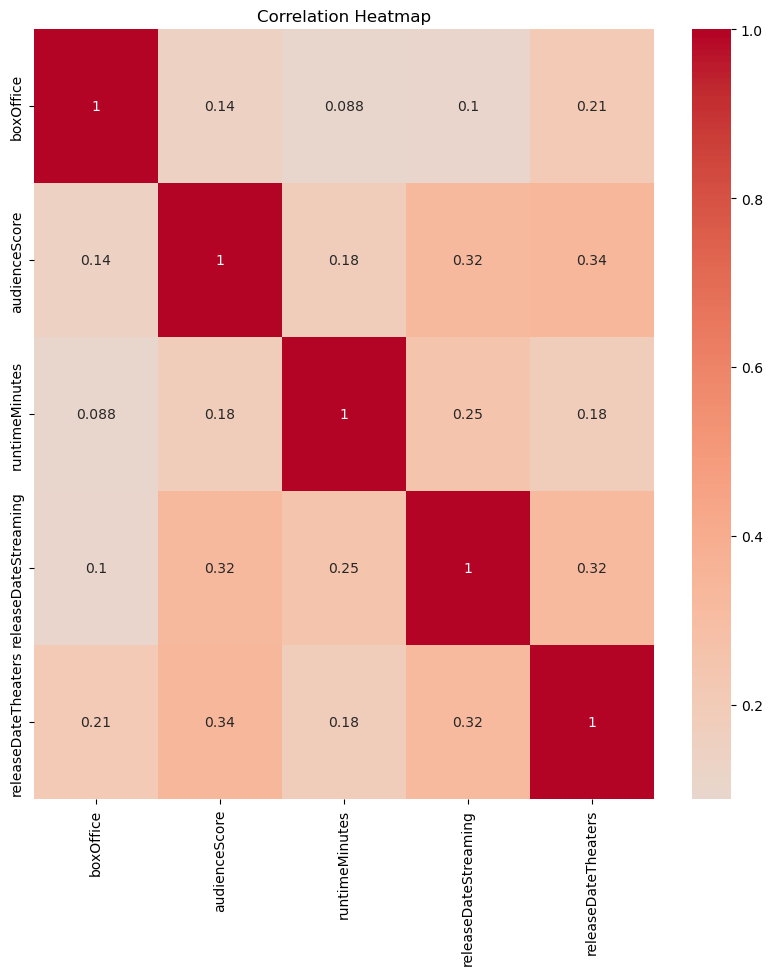

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the dataframe
corr_matrix = grouped_movies.corr()

# Set up the figure and axes for the heatmap
plt.figure(figsize=(10, 10))

# Create a heatmap using seaborn's heatmap function
# display the correlation values in them
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

# Set the title for the heatmap
plt.title('Correlation Heatmap')
plt.show()

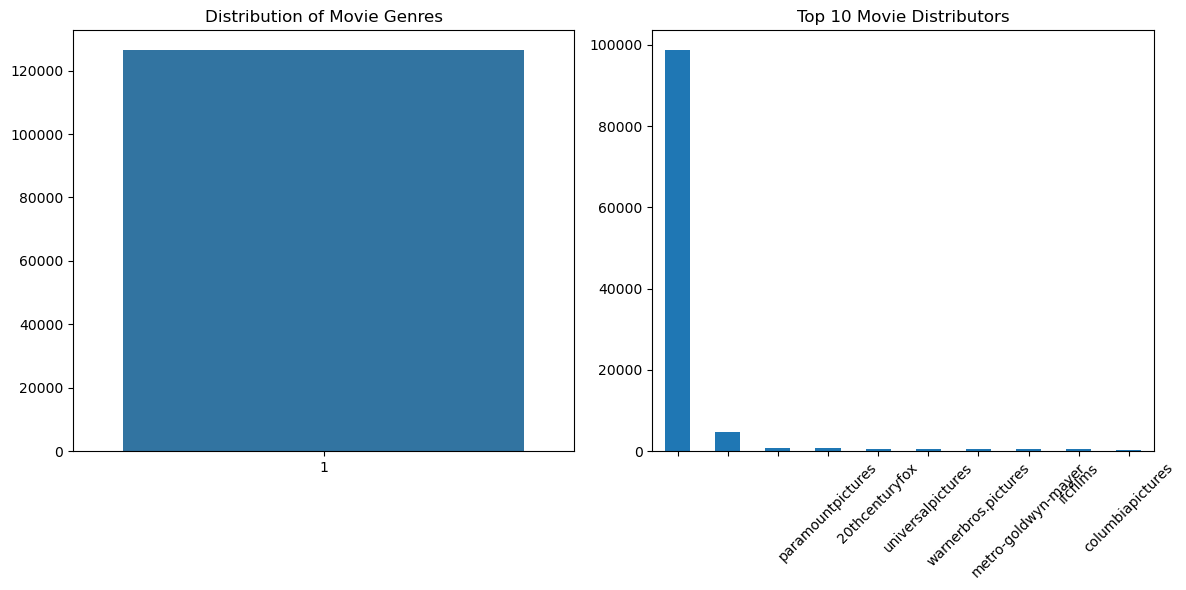

In [6]:

genre_counts = grouped_movies['genre'].str.split(',').apply(len).value_counts()
distributor_counts = grouped_movies['distributor'].value_counts()

# plot the count of movies for each distributor
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Distribution of Movie Genres')

# plot the count of movies for each distributor
plt.subplot(1, 2, 2)
distributor_counts.head(10).plot(kind='bar')
plt.title('Top 10 Movie Distributors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


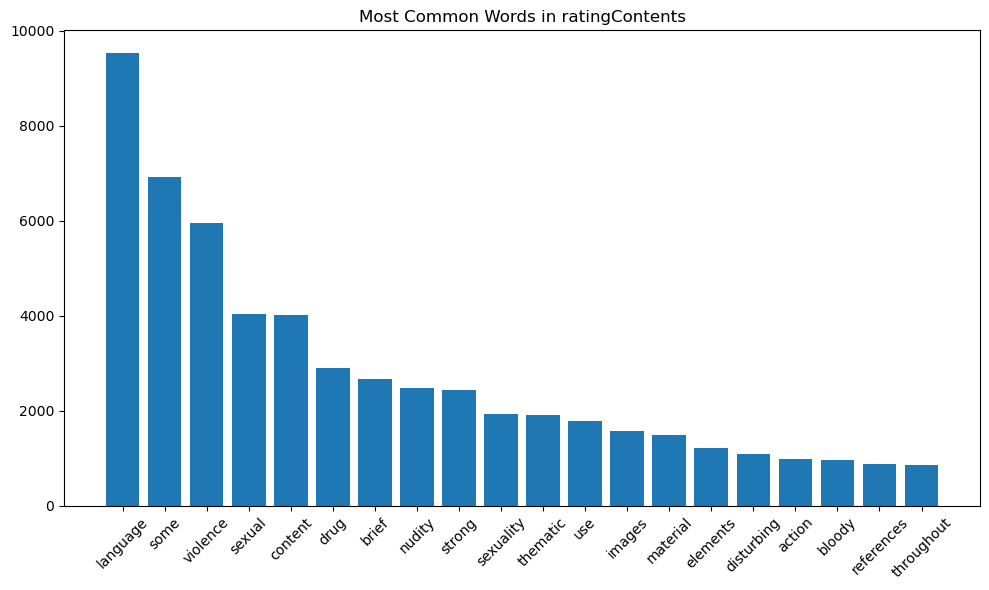

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

text_features = ['ratingContents']

#removed alot of other values as it became messy
#Find the different frequencies of the rating contents
for feature in text_features:
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(grouped_movies[feature])

    word_counts = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()

    plt.figure(figsize=(10, 6))
    common_words = sorted(list(zip(words, word_counts)), key=lambda x: x[1], reverse=True)[:20]
    words, counts = zip(*common_words)
    plt.bar(words, counts)
    plt.title(f'Most Common Words in {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# **import the train and test data**

In [8]:
#sample=pd.read_csv(f"{root}/sample.csv")

#get the datas to be predicted
train=pd.read_csv(f"{root}/train.csv")
train['movieid'] = train['movieid'].replace(r'[^a-zA-Z0-9]', '', regex=True)
test=pd.read_csv(f"{root}/test.csv")
test['movieid'] = test['movieid'].replace(r'[^a-zA-Z0-9]', '', regex=True)


# inspect train data for values

In [9]:
train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelouspirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tonymontanafrodobagginsvrockybalboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darthvaderkatnisseverdeensorcererdonniedarko,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,laracroftglimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jasonbournesurrealtheterminatorindianajones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


# inspect test data

In [10]:
test.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legendmartymcflyoracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminatorkatnisseverdeenglimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,jamesbondlabyrinthgollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,vquesthansolowondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigmahulksurrealstarlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


# Add the movies dataset to the test data

In [11]:
x = pd.merge(train, movies, on='movieid', how='left')
#convert 'isFrequentReviewer' to numeric
x['isFrequentReviewer']=x['isFrequentReviewer'].astype(int)

In [12]:
# find the ratio of postive and negative data in the dataset

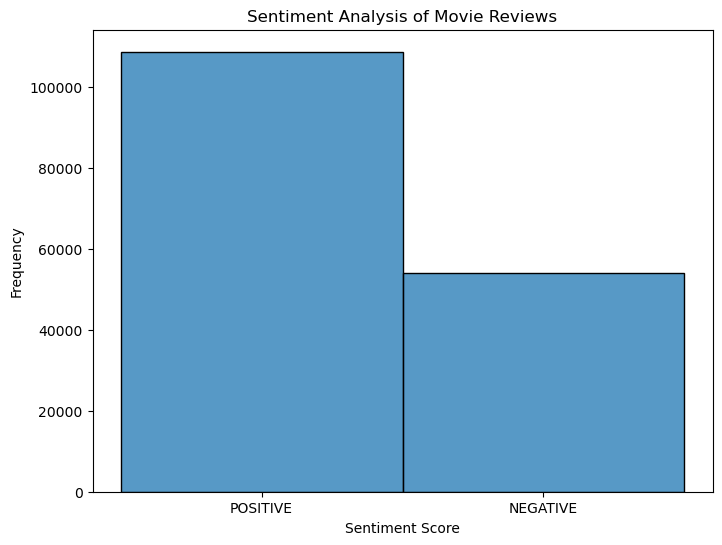

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.histplot(data=x, x='sentiment', bins=20)
plt.title('Sentiment Analysis of Movie Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


# Plot the frequency of words in the dataset

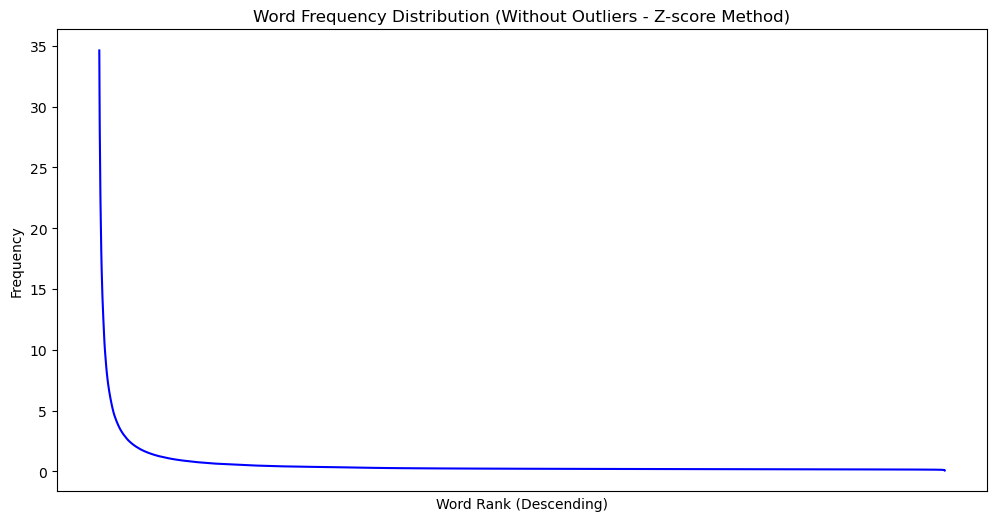

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import zscore

text_data = x['reviewText'].dropna()

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
word_counts = vectorizer.fit_transform(text_data)
word_freq = np.asarray(word_counts.sum(axis=0)).flatten()

# Calculate the Z-scores for each word's frequency
z_scores = zscore(word_freq)

# Calculate the lower and upper bounds for outliers using Z-score method
z_threshold = 3  # 3 is selected as generally Z-score ranges from -3 to 3
outliers = [(word, freq) for word, freq, z_score in zip(range(len(word_freq)), word_freq, z_scores) if abs(z_score) > z_threshold]

# Filter out the outliers from the word frequency distribution
filtered_sorted_word_freq = [(word, freq) for word, freq, z_score in zip(range(len(word_freq)), word_freq, z_scores) if abs(z_score) <= z_threshold]

# Separate the word indices and frequencies after filtering
sorted_indices, sorted_freq = zip(*filtered_sorted_word_freq)

# Sort the frequencies in descending order
sorted_freq_desc = sorted(sorted_freq, reverse=True)

# Plot the word frequency distribution as a line graph
plt.figure(figsize=(12, 6))
plt.plot(sorted_freq_desc, color='blue')
plt.xlabel('Word Rank (Descending)')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution (Without Outliers - Z-score Method)')
plt.xticks([])
plt.show()


# merge test me with movies dataset

In [15]:
test_me = pd.merge(test, movies, on='movieid', how='left')
test_me = test_me.rename(columns={'isTopCritic':'isFrequentReviewer'})
test_me['isFrequentReviewer']=test_me['isFrequentReviewer'].astype(int)

# Delete unnecessary columns

In [16]:
x=x.drop(['releaseDateTheaters', 'director', 'soundType',
             'distributor', 'ratingContents', 'title', 'sentiment'], axis=1) 
test_me=test_me.drop(['releaseDateTheaters','director','soundType',
                      'distributor','ratingContents','title'],axis=1)
y = train['sentiment']
print(x.dtypes)

movieid                  object
reviewerName             object
isFrequentReviewer        int64
reviewText               object
boxOffice               float64
audienceScore           float64
runtimeMinutes          float64
releaseDateStreaming    float64
rating                   object
genre                    object
originalLanguage         object
dtype: object


#Do some basic removals of non alphanumeric values in the reviewtext

In [17]:
import re
def preprocess_text(review):
    review = review.replace("'s", " is")
    review = review.replace("'re", " are")
    review = review.replace("n't", " not")
    review = review.replace("'ve", " have")
    review = review.lower()
    review = re.sub(r"[^a-zA-Z0-9\s]", " ", review)
    return review

In [18]:
x['reviewText'] = x['reviewText'].astype(str).apply(preprocess_text)
test_me['reviewText'] = test_me['reviewText'].astype(str).apply(preprocess_text)
nan_counts = x.isna().sum()
print(nan_counts)
nan_counts = test_me.isna().sum()
print(nan_counts)
#fill na with empty strings
x=x.fillna('')
test_me=test_me.fillna('')


movieid                 0
reviewerName            0
isFrequentReviewer      0
reviewText              0
boxOffice               0
audienceScore           0
runtimeMinutes          0
releaseDateStreaming    0
rating                  0
genre                   0
originalLanguage        0
dtype: int64
movieid                 0
reviewerName            0
isFrequentReviewer      0
reviewText              0
boxOffice               0
audienceScore           0
runtimeMinutes          0
releaseDateStreaming    0
rating                  0
genre                   0
originalLanguage        0
dtype: int64


In [19]:
train['reviewText']=train['reviewText'].fillna('')
test['reviewText']=test['reviewText'].fillna('')
print(x.head())

                                        movieid         reviewerName  \
0                               marvelouspirate       Benjamin Henry   
1           tonymontanafrodobagginsvrockybalboa        Felicia Lopez   
2  darthvaderkatnisseverdeensorcererdonniedarko  Mr. Charles Burgess   
3                              laracroftglimmer         Ryan Barrett   
4   jasonbournesurrealtheterminatorindianajones     Alexander Glover   

   isFrequentReviewer                                         reviewText  \
0                   0  henry selick s first movie since 2009 s corali...   
1                   0  with a cast that reads like the vogue oscar pa...   
2                   1  creed ii does not give us anything but another...   
3                   0  i know what you are thinking  but this is no l...   
4                   0  director fernando meirelles tells the story wi...   

     boxOffice  audienceScore  runtimeMinutes  releaseDateStreaming  rating  \
0          0.0           65.0  

# **procedural removal of too many words**

from sklearn.feature_extraction.text import CountVectorizer

# 1) Divide DataFrame into positive and negative
positive_train = train[train['sentiment'] == 'POSITIVE']
negative_train = train[train['sentiment'] == 'NEGATIVE']

# 2) Get word frequencies for positive and negative sentiments using CountVectorizer
def get_word_frequencies(reviewText):
    vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b\w+\b')
    vectorized_reviewText = vectorizer.fit_transform(reviewText)
    word_freq = vectorized_reviewText.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    return dict(zip(words, word_freq))

positive_word_freq = get_word_frequencies(positive_train['reviewText'])
negative_word_freq = get_word_frequencies(negative_train['reviewText'])
print(positive_word_freq['the'])
print(negative_word_freq['the'])
# 3) Find common words and their frequency differences
common_words = set(positive_word_freq.keys()) & set(negative_word_freq.keys())
word_diff = {word: positive_word_freq[word] - negative_word_freq[word] for word in common_words}
word_freq_pos = {word: (positive_word_freq[word]) for word in common_words}
word_freq_neg = {word: (negative_word_freq[word]) for word in common_words}
# 4): Find stopwords (words occurring in both with non-zero frequency difference)
stopwords = [word for word in word_diff if (word_diff[word]>100 and word_freq_pos[word] > 500 and word_freq_neg[word] > 500)]


# 5) regex coused issues when there were to many words so for loop is used
#stopwords_pattern = r'\b(?:' + ' | '.join(stopwords) + r')\b'
for word in stopwords:
    x['reviewText'] = x['reviewText'].apply(lambda text: text.replace(f' {word} ', ' '))
    test_me['reviewText'] = test_me['reviewText'].apply(lambda text: text.replace(f' {word} ', ' '))

# Display the modified DataFrame
print(x.head())


#for personal inspection, was used to find regex didnt work properly
print(len(stopwords))
if 'the' in stopwords:
    print('Yes')
    print(stopwords.index('the'))


for word in stopwords[0:10]:
    print(word)
    print
    print(word_diff[word])
    print(positive_word_freq[word])
    print(negative_word_freq[word])
print(x.head())


In [20]:
print(x.shape)
x.head()

(162758, 11)


,movieid,reviewerName,isFrequentReviewer,reviewText,boxOffice,audienceScore,runtimeMinutes,releaseDateStreaming,rating,genre,originalLanguage
0,marvelouspirate,Benjamin Henry,0,henry selick s first movie since 2009 s corali...,0.0,65.0,105.000000,20221028.0,PG-13,comedy animation adventure fantasy,English
1,tonymontanafrodobagginsvrockybalboa,Felicia Lopez,0,with a cast that reads like the vogue oscar pa...,110500000.0,47.0,105.000000,20115313.0,PG-13,action holiday romance comedy lgbtq+,English English
2,darthvaderkatnisseverdeensorcererdonniedarko,Mr. Charles Burgess,1,creed ii does not give us anything but another...,115700000.0,80.0,130.000000,20190212.0,PG-13,drama,English
3,laracroftglimmer,Ryan Barrett,0,i know what you are thinking but this is no l...,126500000.0,32.0,84.333333,20175361.0,TVPG R,drama drama action mystery thriller sci-fi,Spanish English English
4,jasonbournesurrealtheterminatorindianajones,Alexander Glover,0,director fernando meirelles tells the story wi...,7600000.0,97.0,131.000000,20040608.0,R,crime drama,Portuguese (Brazil)


# version 356
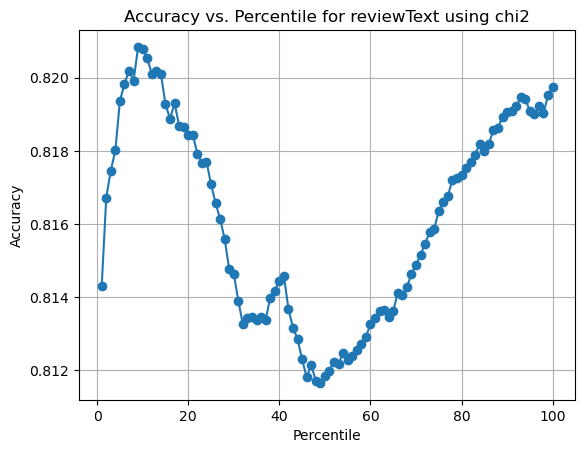

# version 359
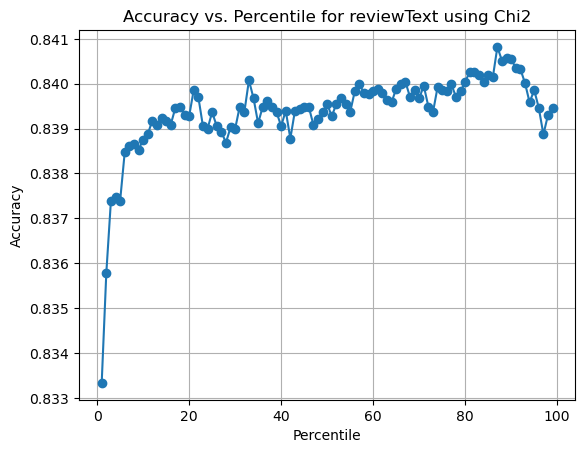

# version 366
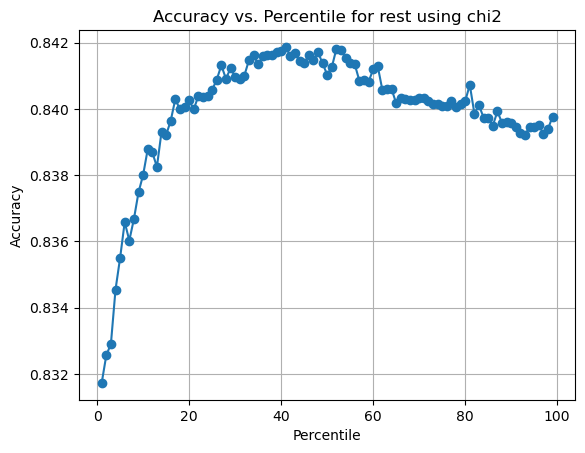

select percentile for character level selection of tranformation

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# pipeline for the 'reviewText' column using TfidfVectorizer
pipe_RText = Pipeline([
    ('CT_RText', ColumnTransformer([
        ('TF_RText', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_df=int(1e6)), 'reviewText'),],
         remainder='drop')),
    ('rm_NoVar',VarianceThreshold()),
    ('rm_Percentile', SelectPercentile(chi2, percentile=89)),
])

# pipeline for characterised 'reviewText' columnusing TfidfVectorizer
pipe_RText_Char = Pipeline([
    ('CT_RText', ColumnTransformer([
        ('TF_RText', TfidfVectorizer(ngram_range=(1, 15), analyzer = 'char',
                                     min_df=1, max_df=int(1e6)), 'reviewText'),],
         remainder='drop')),
    ('rm_NoVar',VarianceThreshold()),
    ('rm_Extras', SelectPercentile(chi2, percentile=3)),
])

# pipeline for the text based non-'reviewText' columns
pipe_Not_RText = Pipeline([
    ('CT_rest', ColumnTransformer([
        ('TF_MId', TfidfVectorizer(ngram_range=(1, 2), binary=False),'movieid'),
        ('TF_genre', TfidfVectorizer(ngram_range=(1, 1), binary=False), 'genre'),
        ('TF_Rating', TfidfVectorizer(ngram_range=(1, 1), binary=False), 'rating'),
        ('TF_OGLang', TfidfVectorizer(ngram_range=(1, 1), binary=False), 'originalLanguage'),
        ('TF_RvName', TfidfVectorizer(ngram_range=(2, 2), binary=False),'reviewerName'),
        ('rm_RText', 'drop', ['reviewText'])],
         remainder='drop')),
    ('rm_NoVar',VarianceThreshold()),
    ('rm_Percentile', SelectPercentile(chi2, percentile=38)),
])

# pipeline for numeric columns
pipe_rest = Pipeline([
    ('CT_rest', ColumnTransformer([
        ('Scale_Num', RobustScaler() ,['audienceScore', 'runtimeMinutes',
                                        'boxOffice','releaseDateStreaming']),
        ('rm_RText', 'drop', ['reviewText', 'movieid', 'genre', 'rating',
                              'originalLanguage', 'reviewerName'])],
         remainder='passthrough')),
])

# merge output of all pipelines
all_Features = FeatureUnion([
    ('pipe_RText', pipe_RText),
    ('pipe_RText_Char', pipe_RText_Char),
    ('pipe_Not_RText', pipe_Not_RText),
    ('pipe_rest', pipe_rest)
])

#base estimator
pipe_SVC = Pipeline([
    ('all_Features',all_Features),
    ('model',LinearSVC(max_iter=1000,dual=False, loss='squared_hinge',
                       C=.5,tol = 7e-5, random_state=42))
])

pipe_LogReg = Pipeline([
    ('all_Features',all_Features),
    ('model',LogisticRegression(random_state=42, max_iter=5000,
                                   C=1.2, fit_intercept=True, solver='lbfgs'))
])

pipe_MLP = Pipeline([
    ('all_Features',all_Features),
    ('model',MLPClassifier(hidden_layer_sizes=(10,10,10), activation='relu',
                              solver='lbfgs', max_iter=1000,
                                  random_state=42, early_stopping=True))
])


# Commented out code for Logistic Regression model HPT

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2, VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define your parameter grid for Logistic Regression
param_grid_lr = {
    'model__C': [ 0.5, 1, 1.2],
    'model__fit_intercept': [True, False],
    'model__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
}



# Create a pipeline for preprocessing and modeling
pipe_RText = Pipeline([
    ('CT_RText', ColumnTransformer([
        ('TF_RText', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_df=int(1e6)), 'reviewText'),
    ], remainder='drop')),
    ('rm_NoVar', VarianceThreshold()),
])

pipe_not_RText = Pipeline([
    ('CT_rest', ColumnTransformer([
        ('TF_MId', TfidfVectorizer(ngram_range=(1, 2), binary=False), 'movieid'),
        ('TF_genre', TfidfVectorizer(ngram_range=(1, 1), binary=False), 'genre'),
        ('TF_Rating', TfidfVectorizer(ngram_range=(1, 1), binary=False), 'rating'),
        ('TF_OGLang', TfidfVectorizer(ngram_range=(1, 1), binary=False), 'originalLanguage'),
        ('TF_RvName', TfidfVectorizer(ngram_range=(2, 2), binary=False), 'reviewerName'),
    ], remainder='drop')),
    ('rm_NoVar', VarianceThreshold()),
])

pipe_rest = Pipeline([
    ('CT_rest', ColumnTransformer([
        ('Scale_Num', RobustScaler(), ['audienceScore', 'runtimeMinutes', 'boxOffice', 'releaseDateStreaming']),
        ('rm_RText', 'drop', ['reviewText', 'movieid', 'genre', 'rating', 'originalLanguage', 'reviewerName']),
    ], remainder='passthrough')),
])

all_Features = FeatureUnion([
    ('CT_RText', pipe_RText),
    ('CT_not_RText', pipe_not_RText),
    ('numeric_features', pipe_rest)
])

pipe_model = Pipeline([
    ('all_Features', all_Features),
    ('model', LogisticRegression(random_state=42, max_iter=5000))
])

# Perform GridSearchCV
grid_search = GridSearchCV(pipe_model, param_grid_lr, scoring='accuracy', cv=3, verbose=4, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(f"Best Parameters: {best_params}, Best Accuracy: {best_accuracy}")
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END model__C=0.5, model__fit_intercept=True, model__solver=lbfgs;, score=0.814 total time= 9.4min
[CV 2/3] END model__C=0.5, model__fit_intercept=True, model__solver=sag;, score=0.808 total time=16.3min
[CV 1/3] END model__C=0.5, model__fit_intercept=False, model__solver=lbfgs;, score=0.813 total time= 8.9min
[CV 3/3] END model__C=0.5, model__fit_intercept=False, model__solver=lbfgs;, score=0.814 total time= 8.9min
[CV 3/3] END model__C=0.5, model__fit_intercept=False, model__solver=sag;, score=0.805 total time=15.6min
[CV 1/3] END model__C=1, model__fit_intercept=True, model__solver=lbfgs;, score=0.822 total time=10.7min
[CV 3/3] END model__C=1, model__fit_intercept=True, model__solver=lbfgs;, score=0.823 total time=12.3min
[CV 1/3] END model__C=1, model__fit_intercept=True, model__solver=saga;, score=0.800 total time=19.9min
[CV 2/3] END model__C=1, model__fit_intercept=False, model__solver=lbfgs;, score=0.825 total time=13.8min
[CV 1/3] END model__C=1, model__fit_intercept=False, model__solver=liblinear;, score=0.823 total time= 1.4min
[CV 2/3] END model__C=1, model__fit_intercept=False, model__solver=liblinear;, score=0.824 total time= 1.4min
[CV 3/3] END model__C=1, model__fit_intercept=False, model__solver=liblinear;, score=0.823 total time= 1.3min
[CV 1/3] END model__C=1, model__fit_intercept=False, model__solver=sag;, score=0.810 total time=19.2min
[CV 2/3] END model__C=1, model__fit_intercept=False, model__solver=saga;, score=0.805 total time=25.0min
[CV 2/3] END model__C=1.2, model__fit_intercept=True, model__solver=sag;, score=0.817 total time=22.9min
[CV 1/3] END model__C=1.2, model__fit_intercept=False, model__solver=lbfgs;, score=0.824 total time=13.1min
[CV 3/3] END model__C=1.2, model__fit_intercept=False, model__solver=lbfgs;, score=0.825 total time=10.9min
[CV 1/3] END model__C=1.2, model__fit_intercept=False, model__solver=saga;, score=0.800 total time=20.1min
[CV 3/3] END model__C=0.5, model__fit_intercept=True, model__solver=lbfgs;, score=0.814 total time=10.0min
[CV 1/3] END model__C=0.5, model__fit_intercept=True, model__solver=saga;, score=0.794 total time=16.8min
[CV 2/3] END model__C=0.5, model__fit_intercept=False, model__solver=lbfgs;, score=0.816 total time= 9.5min
[CV 1/3] END model__C=0.5, model__fit_intercept=False, model__solver=liblinear;, score=0.813 total time= 1.2min
[CV 2/3] END model__C=0.5, model__fit_intercept=False, model__solver=liblinear;, score=0.816 total time= 1.2min
[CV 3/3] END model__C=0.5, model__fit_intercept=False, model__solver=liblinear;, score=0.814 total time= 1.1min
[CV 1/3] END model__C=0.5, model__fit_intercept=False, model__solver=sag;, score=0.804 total time=15.0min
[CV 2/3] END model__C=0.5, model__fit_intercept=False, model__solver=saga;, score=0.799 total time=20.3min
[CV 2/3] END model__C=1, model__fit_intercept=True, model__solver=liblinear;, score=0.824 total time= 1.3min
[CV 1/3] END model__C=1, model__fit_intercept=True, model__solver=sag;, score=0.811 total time=19.9min
[CV 2/3] END model__C=1, model__fit_intercept=True, model__solver=saga;, score=0.805 total time=24.8min
[CV 3/3] END model__C=1, model__fit_intercept=False, model__solver=sag;, score=0.813 total time=20.6min
[CV 3/3] END model__C=1, model__fit_intercept=False, model__solver=saga;, score=0.801 total time=22.9min
[CV 3/3] END model__C=1.2, model__fit_intercept=True, model__solver=sag;, score=0.814 total time=22.3min
[CV 3/3] END model__C=1.2, model__fit_intercept=True, model__solver=saga;, score=0.803 total time=24.0min
[CV 3/3] END model__C=1.2, model__fit_intercept=False, model__solver=sag;, score=0.815 total time=21.8min
[CV 2/3] END model__C=0.5, model__fit_intercept=True, model__solver=lbfgs;, score=0.817 total time= 9.7min
[CV 3/3] END model__C=0.5, model__fit_intercept=True, model__solver=sag;, score=0.805 total time=15.6min
[CV 3/3] END model__C=0.5, model__fit_intercept=True, model__solver=saga;, score=0.796 total time=19.7min
[CV 1/3] END model__C=0.5, model__fit_intercept=False, model__solver=saga;, score=0.793 total time=16.4min
[CV 2/3] END model__C=1, model__fit_intercept=True, model__solver=lbfgs;, score=0.824 total time=12.4min
[CV 1/3] END model__C=1, model__fit_intercept=True, model__solver=liblinear;, score=0.822 total time= 1.3min
[CV 3/3] END model__C=1, model__fit_intercept=True, model__solver=liblinear;, score=0.823 total time= 1.4min
[CV 2/3] END model__C=1, model__fit_intercept=True, model__solver=sag;, score=0.816 total time=21.8min
[CV 3/3] END model__C=1, model__fit_intercept=True, model__solver=saga;, score=0.801 total time=23.8min
[CV 1/3] END model__C=1, model__fit_intercept=False, model__solver=saga;, score=0.799 total time=19.8min
[CV 2/3] END model__C=1.2, model__fit_intercept=True, model__solver=lbfgs;, score=0.826 total time=13.4min
[CV 1/3] END model__C=1.2, model__fit_intercept=True, model__solver=liblinear;, score=0.824 total time= 1.4min
[CV 2/3] END model__C=1.2, model__fit_intercept=True, model__solver=liblinear;, score=0.826 total time= 1.3min
[CV 3/3] END model__C=1.2, model__fit_intercept=True, model__solver=liblinear;, score=0.825 total time= 1.5min
[CV 1/3] END model__C=1.2, model__fit_intercept=True, model__solver=sag;, score=0.812 total time=21.0min
[CV 2/3] END model__C=1.2, model__fit_intercept=True, model__solver=saga;, score=0.806 total time=26.1min
[CV 2/3] END model__C=1.2, model__fit_intercept=False, model__solver=sag;, score=0.817 total time=22.9min
[CV 3/3] END model__C=1.2, model__fit_intercept=False, model__solver=saga;, score=0.802 total time=15.4min
[CV 1/3] END model__C=0.5, model__fit_intercept=True, model__solver=liblinear;, score=0.814 total time= 1.2min
[CV 2/3] END model__C=0.5, model__fit_intercept=True, model__solver=liblinear;, score=0.816 total time= 1.3min
[CV 3/3] END model__C=0.5, model__fit_intercept=True, model__solver=liblinear;, score=0.814 total time= 1.3min
[CV 1/3] END model__C=0.5, model__fit_intercept=True, model__solver=sag;, score=0.805 total time=15.9min
[CV 2/3] END model__C=0.5, model__fit_intercept=True, model__solver=saga;, score=0.799 total time=21.1min
[CV 2/3] END model__C=0.5, model__fit_intercept=False, model__solver=sag;, score=0.808 total time=16.2min
[CV 3/3] END model__C=0.5, model__fit_intercept=False, model__solver=saga;, score=0.796 total time=19.7min
[CV 3/3] END model__C=1, model__fit_intercept=True, model__solver=sag;, score=0.812 total time=21.8min
[CV 1/3] END model__C=1, model__fit_intercept=False, model__solver=lbfgs;, score=0.822 total time=11.0min
[CV 3/3] END model__C=1, model__fit_intercept=False, model__solver=lbfgs;, score=0.823 total time=11.2min
[CV 2/3] END model__C=1, model__fit_intercept=False, model__solver=sag;, score=0.815 total time=21.0min
[CV 1/3] END model__C=1.2, model__fit_intercept=True, model__solver=lbfgs;, score=0.824 total time=12.9min
[CV 3/3] END model__C=1.2, model__fit_intercept=True, model__solver=lbfgs;, score=0.825 total time=12.8min
[CV 1/3] END model__C=1.2, model__fit_intercept=True, model__solver=saga;, score=0.801 total time=21.2min
[CV 2/3] END model__C=1.2, model__fit_intercept=False, model__solver=lbfgs;, score=0.826 total time=12.5min
[CV 1/3] END model__C=1.2, model__fit_intercept=False, model__solver=liblinear;, score=0.824 total time= 1.4min
[CV 2/3] END model__C=1.2, model__fit_intercept=False, model__solver=liblinear;, score=0.826 total time= 1.4min
[CV 3/3] END model__C=1.2, model__fit_intercept=False, model__solver=liblinear;, score=0.825 total time= 1.4min
[CV 1/3] END model__C=1.2, model__fit_intercept=False, model__solver=sag;, score=0.811 total time=21.0min
[CV 2/3] END model__C=1.2, model__fit_intercept=False, model__solver=saga;, score=0.806 total time=18.5min
Best Parameters: {'model__C': 1.2, 'model__fit_intercept': True, 'model__solver': 'lbfgs'}, Best Accuracy: 0.8251179400857701

# version 111

Max accuracy for LogReg is 
0.84649

# HPT for MLPClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


# Define the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes': [(10,), (10,10), (10, 10, 10), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}

# Create an MLPClassifier instance
mlp = MLPClassifier(max_iter=1000)

# Create a GridSearchCV instance
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV to the data
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

# version 535

Max Accuracy for MLP is
*0.85197*

# HPT for LinearSVC

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'tol': [1e-5,3e-5,5e-5,7e-5,9e-5,1e-4,3e-4,5e-4,7e-4,9e-4]
    'loss': ['hinge', 'squared_hinge'],
}

# Create a LinearSVC model
model = LinearSVC()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy of Best Model:", test_accuracy)


# version 516
best accuracy for linear SVC is
0.85329

In [22]:
from sklearn.ensemble import StackingClassifier

#final estimator
stacking_clf = StackingClassifier(estimators=[('LSVC_norm', pipe_SVC)],
                    final_estimator=LinearSVC(max_iter=1000, dual=False,
        loss='squared_hinge', C=0.5, tol=7e-5, random_state=42), cv=3)

In [23]:
from sklearn.model_selection import train_test_split
x, test_me, y, y_test = train_test_split(x, y, test_size=.2, random_state=42)

In [24]:
stacking_clf.fit(x,y)

StackingClassifier(cv=3,
                   estimators=[('LSVC_norm',
                                Pipeline(steps=[('all_Features',
                                                 FeatureUnion(transformer_list=[('pipe_RText',
                                                                                 Pipeline(steps=[('CT_RText',
                                                                                                  ColumnTransformer(transformers=[('TF_RText',
                                                                                                                                   TfidfVectorizer(max_df=1000000,
                                                                                                                                                   ngram_range=(1,
                                                                                                                                                                2)),
                                                                                                                                   'reviewText')])),
                                                                                                 ('rm_NoVar',
                                                                                                  VarianceThreshold()),
                                                                                                 ('rm_Percentile',
                                                                                                  SelectPercentile(percentile=89,
                                                                                                                   scor...
                                                                                                                    transformers=[('Scale_Num',
                                                                                                                                   RobustScaler(),
                                                                                                                                   ['audienceScore',
                                                                                                                                    'runtimeMinutes',
                                                                                                                                    'boxOffice',
                                                                                                                                    'releaseDateStreaming']),
                                                                                                                                  ('rm_RText',
                                                                                                                                   'drop',
                                                                                                                                   ['reviewText',
                                                                                                                                    'movieid',
                                                                                                                                    'genre',
                                                                                                                                    'rating',
                                                                                                                                    'originalLanguage',
                                                                                                                                    'reviewerName'])]))]))])),
                                                ('model',
                                                 LinearSVC(C=0.5, dual=False,
                                                           random_state=42,
         

top postive and negative features

# report of the results on training data

Accuracy on training data: 0.8424981567952814
Classification Report on training data:
              precision    recall  f1-score   support

    NEGATIVE       0.79      0.71      0.75     10696
    POSITIVE       0.87      0.90      0.89     21856

    accuracy                           0.84     32552
   macro avg       0.83      0.81      0.82     32552
weighted avg       0.84      0.84      0.84     32552

Confusion Matrix on training data:
[[ 7647  3049]
 [ 2078 19778]]


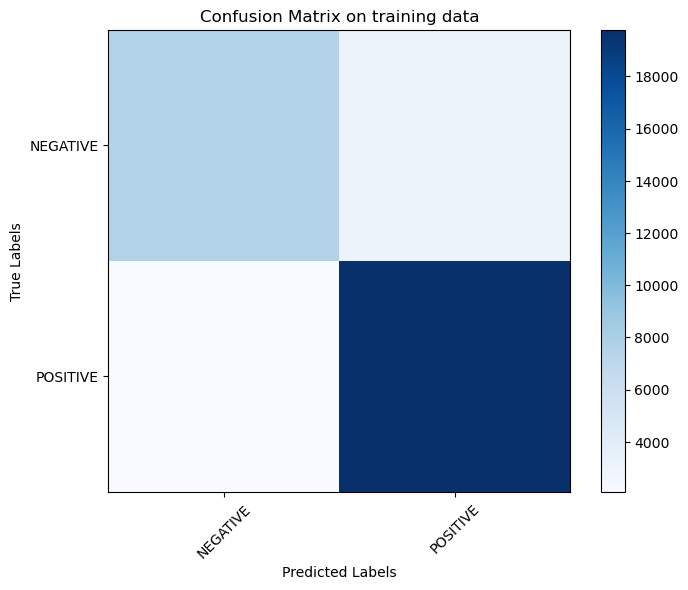

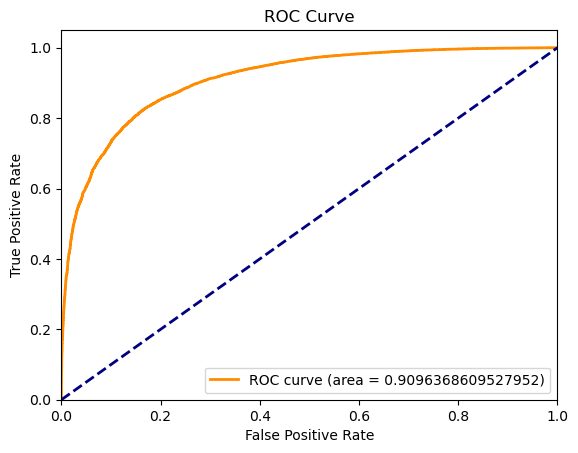

In [25]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix
y=y_test

t_predict = stacking_clf.predict(test_me)

"""post computation reports"""
#accuracy
accuracy_train = accuracy_score(y, t_predict)
print(f"Accuracy on training data: {accuracy_train}")

#classificiation report containing all the necessary values
print("Classification Report on training data:")
print(classification_report(y, t_predict))

#finding the confusion matrix and plotting it as a graph 
conf_matrix_train = confusion_matrix(y, t_predict)
print("Confusion Matrix on training data:")
print(conf_matrix_train)
y = np.where(y == 'POSITIVE', 1, 0)

classes=["NEGATIVE","POSITIVE"]
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_train, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix on training data")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.show()

decision_scores = stacking_clf.decision_function(test_me)

# Apply sigmoid function to decision scores to get pseudo probabilities
proba = 1 / (1 + np.exp(-decision_scores))

# Calculate ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y, proba)
# Calculate the ROC curve and AUC for training data
roc_auc_train = auc(fpr_train, tpr_train)

# Plot the ROC curve for training data
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc_train})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
y=y_test


# submission predictions

In [26]:
prediction = stacking_clf.predict(test_me)

# to figure out how duplicates work

from sklearn.preprocessing import LabelEncoder

trainer_predictions = t_predict
trainer = train.copy()
#feature engineering of the number of duplicates
#feature engineering of number of duplicates above the current entry
trainer['interim']=trainer_predictions
trainer['dup_index'] = trainer.groupby(['reviewerName','movieid']).cumcount()-1
dup_count = trainer.groupby(['reviewerName', 'movieid']).size().reset_index(name='dup_count')

trainer = pd.merge(trainer, dup_count, on=['reviewerName', 'movieid'], how='left')
trainer = trainer.drop(['sentiment','reviewText','movieid','reviewerName','isFrequentReviewer'], axis=1)
enc = LabelEncoder()
trainer['interim']=enc.fit_transform(trainer['interim'])

tester_predictions = prediction
tester = test.copy()

tester['interim']=prediction
tester['dup_index'] = tester.groupby(['reviewerName','movieid']).cumcount()-1
dup_count = tester.groupby(['reviewerName', 'movieid']).size().reset_index(name='dup_count')

tester = pd.merge(tester, dup_count, on=['reviewerName', 'movieid'], how='left')
tester = tester.drop(['reviewText','movieid','reviewerName','isTopCritic'], axis=1)
tester['interim']=enc.transform(tester['interim'])
tester.head()

modeler = LinearSVC()
modeler.fit(trainer, y)
predictions = modeler.predict(tester)

In [27]:
submission = pd.DataFrame(columns=['id','sentiment'])
submission['id']=[i for i in range(len(prediction))]
submission['sentiment']=prediction

In [28]:
print(submission.shape)
print(test.shape)
submission.info
submission.to_csv('submission.csv', index=False)

(32552, 2)
(55315, 4)
